### Importing Libraries

In [27]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

### Pre Processing Step

In [28]:
# Load the CSV
file_path = "NewsData.io_TSLA.csv"  # Adjust path if needed
df = pd.read_csv("NewsData.io_TSLA.csv", on_bad_lines='skip')


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16494 entries, 0 to 16493
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_id       16494 non-null  object
 1   title            16494 non-null  object
 2   link             16494 non-null  object
 3   keywords         12090 non-null  object
 4   creator          14762 non-null  object
 5   video_url        2 non-null      object
 6   description      16026 non-null  object
 7   content          14697 non-null  object
 8   pubDate          16494 non-null  object
 9   pubDateTZ        16494 non-null  object
 10  image_url        14663 non-null  object
 11  source_id        16494 non-null  object
 12  source_priority  16494 non-null  object
 13  source_name      16426 non-null  object
 14  source_url       16425 non-null  object
 15  source_icon      16361 non-null  object
 16  language         16494 non-null  object
 17  country          16491 non-null

In [30]:
df["ai_tag"].value_counts()

,count
ai_tag,
"""financial markets""",6168
"""automotive""",4174
"""corporate news""",1270
"""awards and recognitions""",408
"""corporate news,financial markets""",407
...,...
"""startups & entrepreneurship,awards and recognitions""",1
"""aviation,space""",1
"""american football,accidents""",1


In [31]:
# Checking distinct languages and counting values
df['language'].value_counts()

,count
language,
"""english""",13620
"""spanish""",2826
"""german""",14
"""french""",13
"""romanian""",10
"""portuguese""",2
"""financial markets""",2
"""italian""",2
"""united states of america,colombia,mexico,argentina""",1


In [32]:
# Drop rows with missing sentiment or content
df_en = df.dropna(subset=["sentiment", "content"])

# Storing only english content in new df
df_en = df_en[df_en['language'] == '"english"']

# Quick look
df_en[["pubDate", "title", "sentiment"]].head()

,pubDate,title,sentiment
0,"""2025-01-15 22:16:52""","""My Prediction for 2025 – and a Profit-Generat...","""positive"""
1,"""2025-01-15 22:00:00""","""Boeing needs 'tough love,' says Trump's trans...","""positive"""
6,"""2025-01-15 21:13:08""","""NASDAQ snaps five-day losing streak with its ...","""positive"""
7,"""2025-01-15 20:55:20""","""What's Going On With Tesla Shares Wednesday?""","""neutral"""
8,"""2025-01-15 20:42:47""","""Electric Vehicle Sales Leaders — Best Selling...","""neutral"""


In [33]:
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Download necessary resources (only once)
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")


# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Map POS tags to WordNet equivalents
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Preprocessing function
def basic_preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = text.split()
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]

    # POS tagging and lemmatization
    tagged_tokens = pos_tag(tokens)
    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in tagged_tokens
    ]

    lemmatized = [w for w in lemmatized if len(w) > 1]
    return " ".join(lemmatized)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [34]:
# Show original content
df_en["content"].head(5)

,content
0,"""Hello, Reader. Mark Twain once remarked, “The..."
1,"""President-elect Donald Trump’s nominee to suc..."
6,"""The major stock indices cheered on the combin..."
7,"""Tesla, Inc . TSLA stock is trading higher on ..."
8,"""A closer look at the best-selling PEV automot..."


In [35]:
# Apply to content
df_en["clean_content"] = df_en["content"].apply(basic_preprocess)
df_en["clean_title"] = df_en["title"].apply(basic_preprocess)
df_en["clean_description"] = df_en["description"].apply(basic_preprocess)

### Plot Most Common Function

In [36]:
def plot_most_common_features(text_col, target_col, n_features=50):
    from matplotlib import interactive

    df = pd.DataFrame({"text": text_col, "CLASS": target_col})
    grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
    grouped_df = pd.DataFrame({"CLASS": grouped.index, "text": grouped.values})

    from nltk.tokenize import WhitespaceTokenizer
    tokenizer = WhitespaceTokenizer()

    for ii, text in enumerate(grouped_df.text):
        pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))
        plt.title(grouped_df.CLASS[ii], fontsize=20)
        plt.xticks(fontsize=15)
        plt.legend([])
        interactive(True)
        plt.show()

### Plot most common - Clean Content

<ipython-input-36-3495920787>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
<ipython-input-36-3495920787>:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


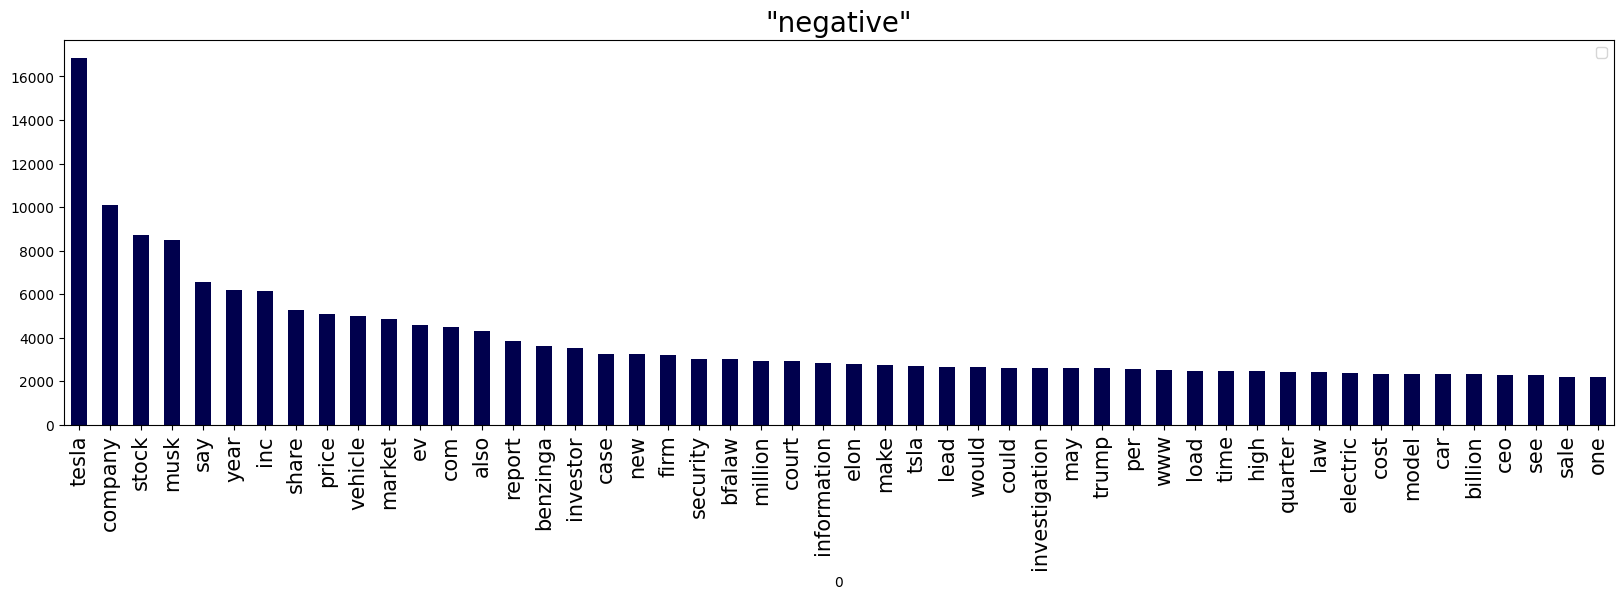

<ipython-input-36-3495920787>:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


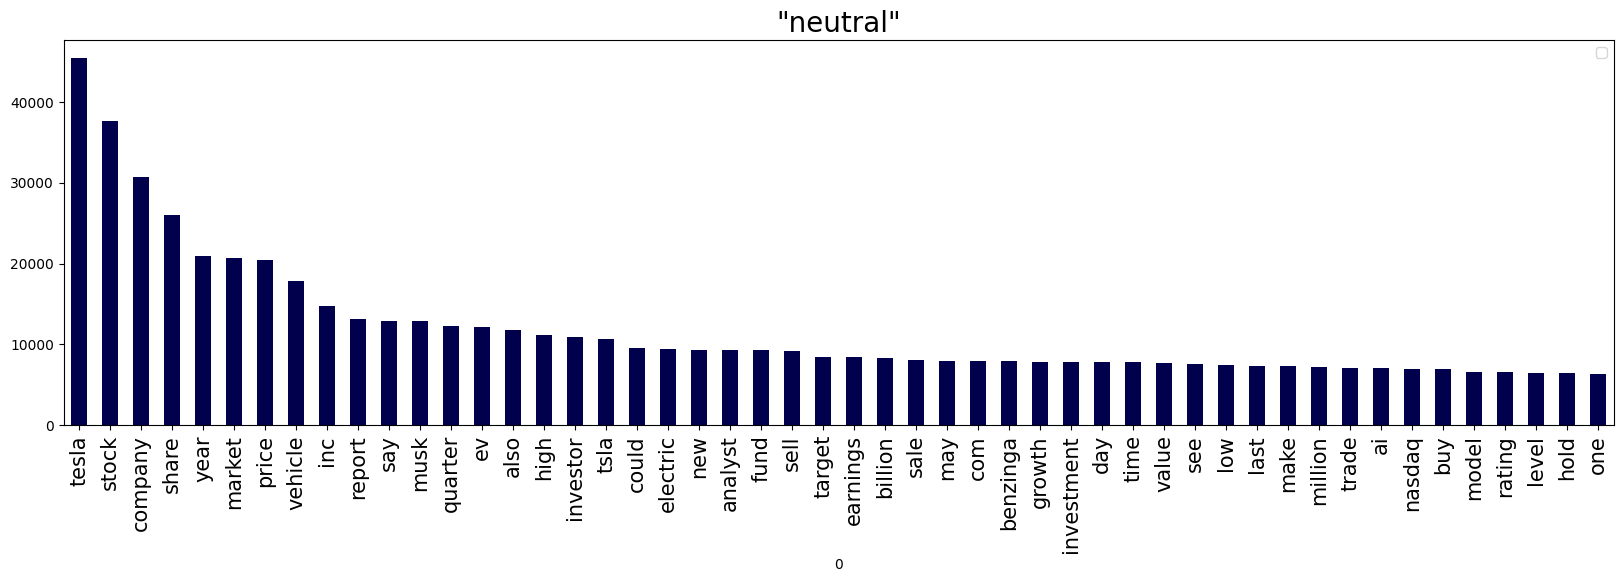

<ipython-input-36-3495920787>:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


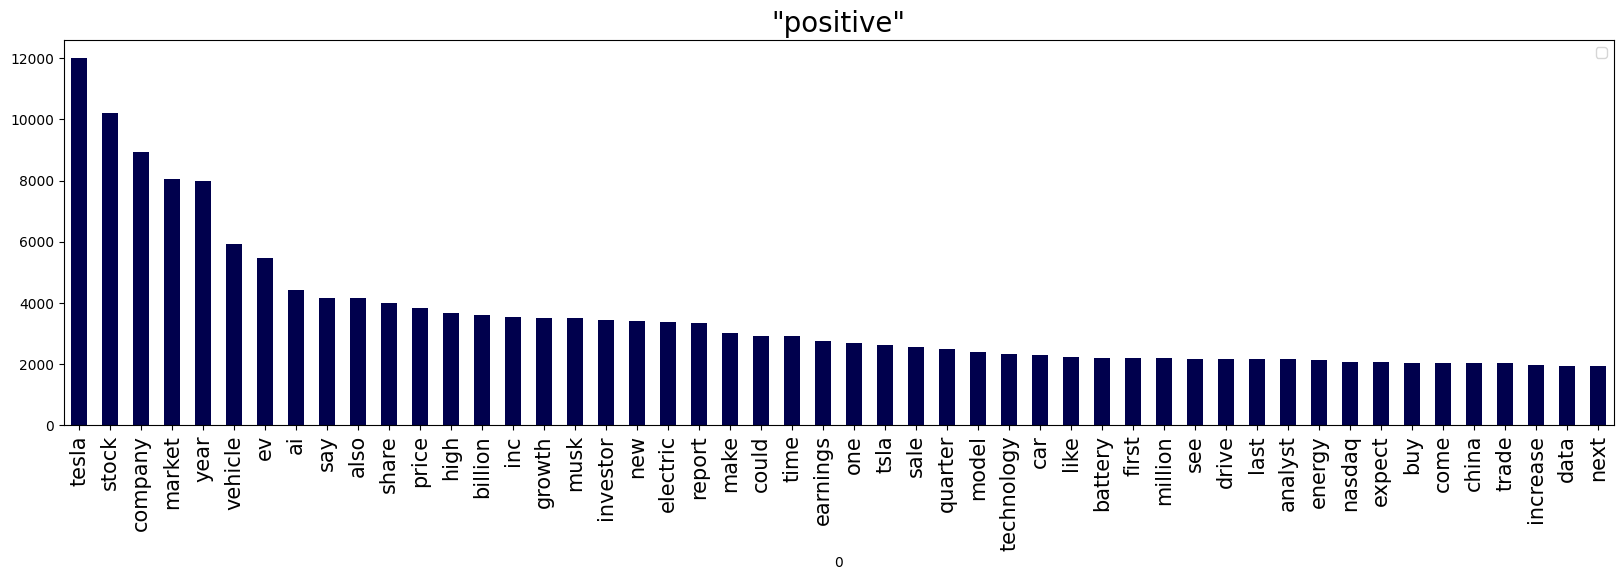

In [37]:
plot_most_common_features(df_en.clean_content, df_en.sentiment)

###  Plot most common - Clean Title

<ipython-input-36-3495920787>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
<ipython-input-36-3495920787>:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


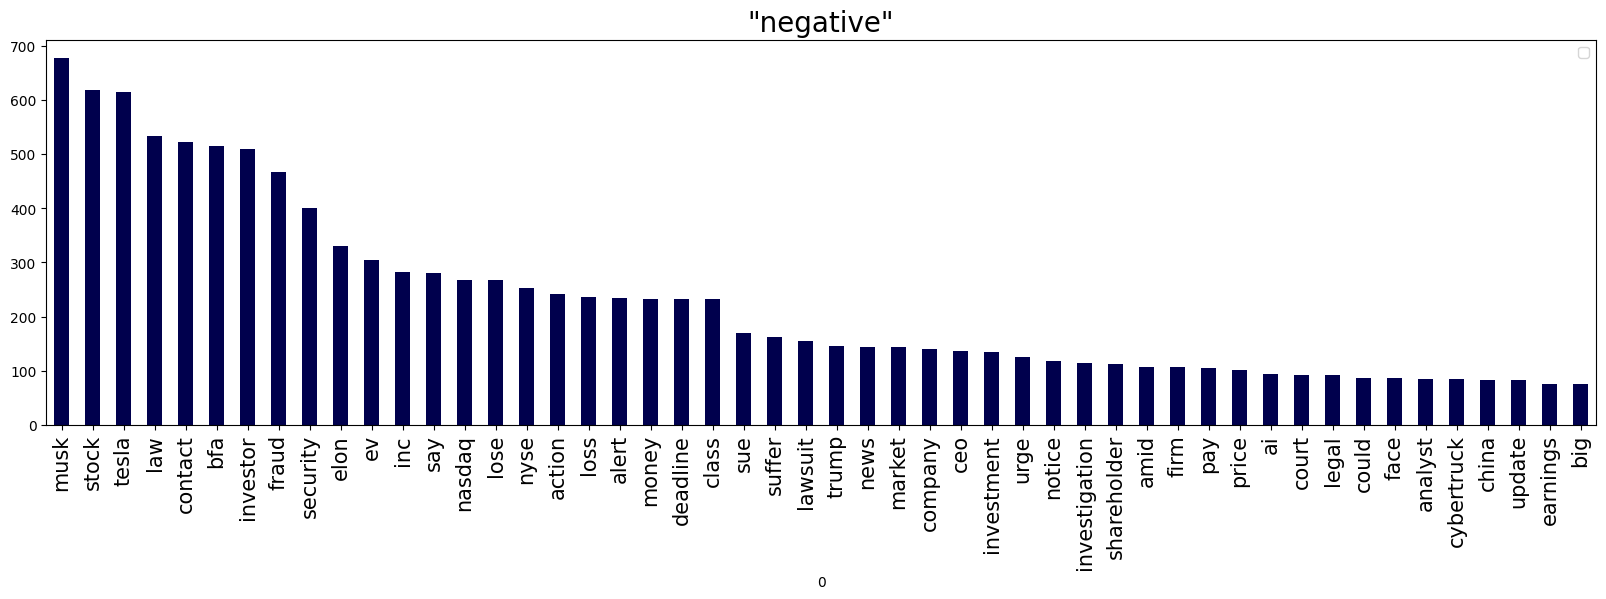

<ipython-input-36-3495920787>:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


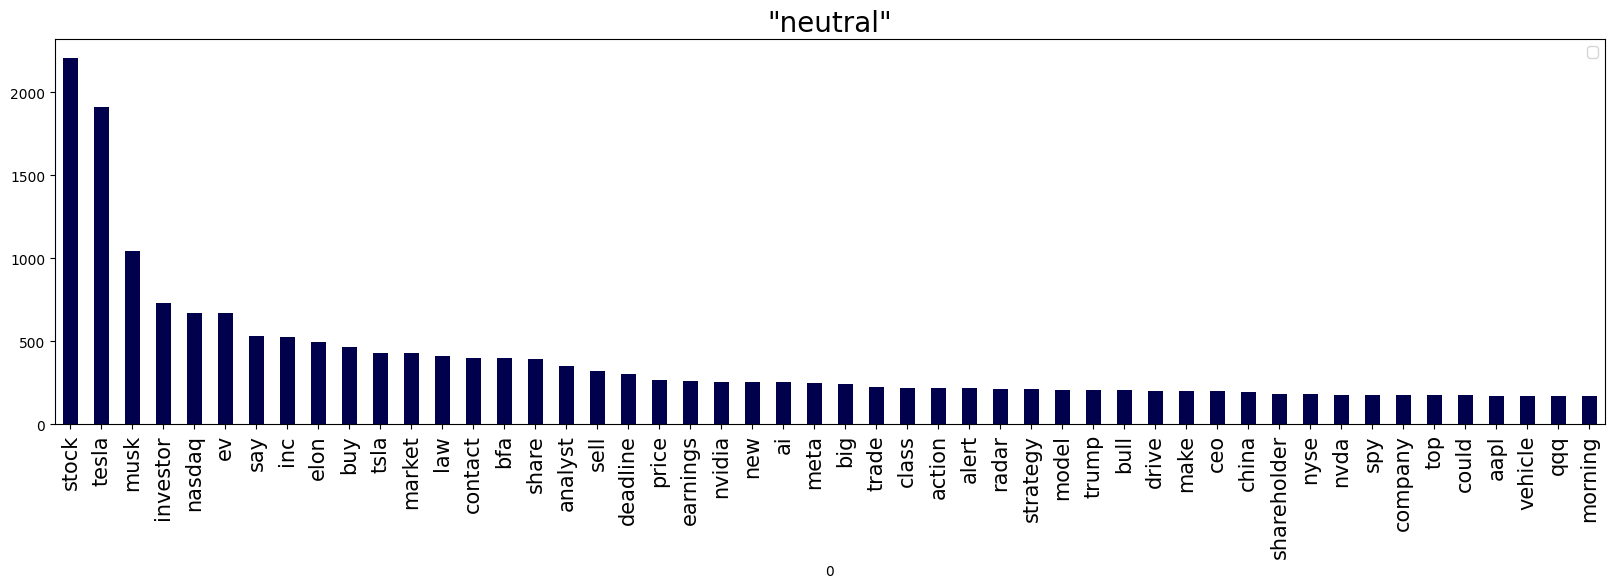

<ipython-input-36-3495920787>:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


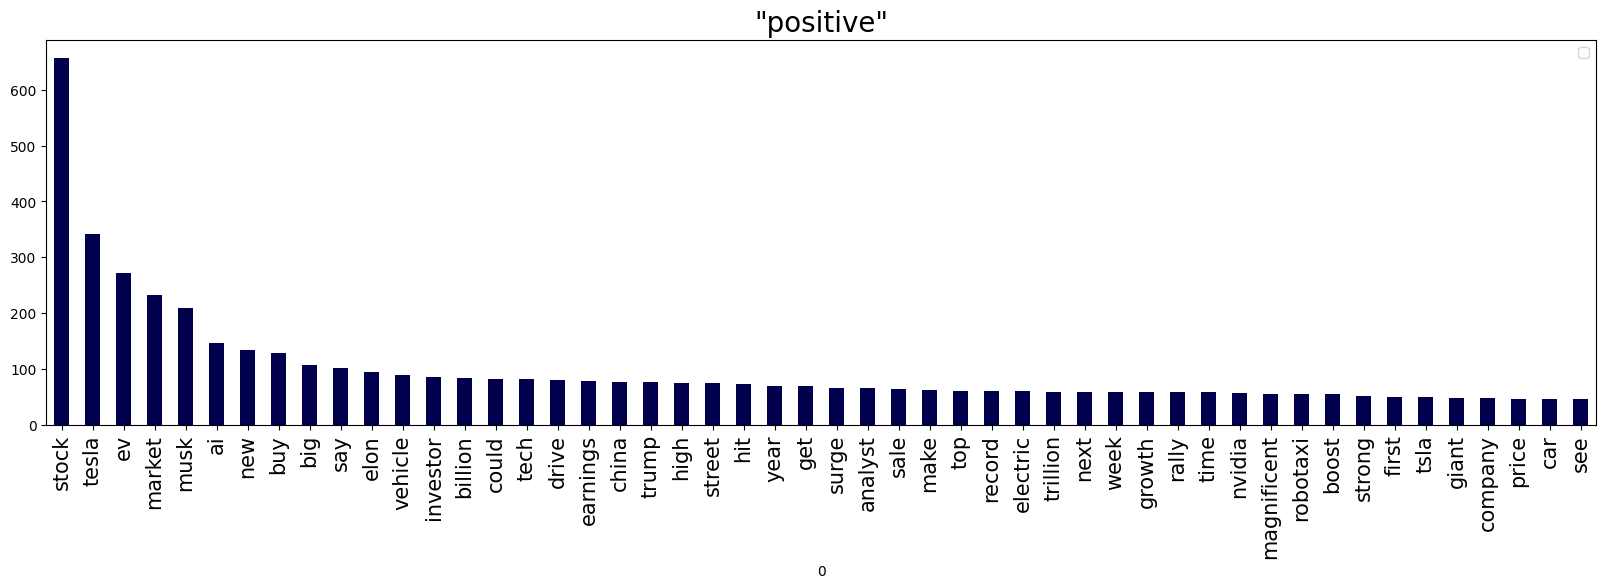

In [38]:
plot_most_common_features(df_en.clean_title, df_en.sentiment)

###  Plot most common - Clean Description

<ipython-input-36-3495920787>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
<ipython-input-36-3495920787>:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


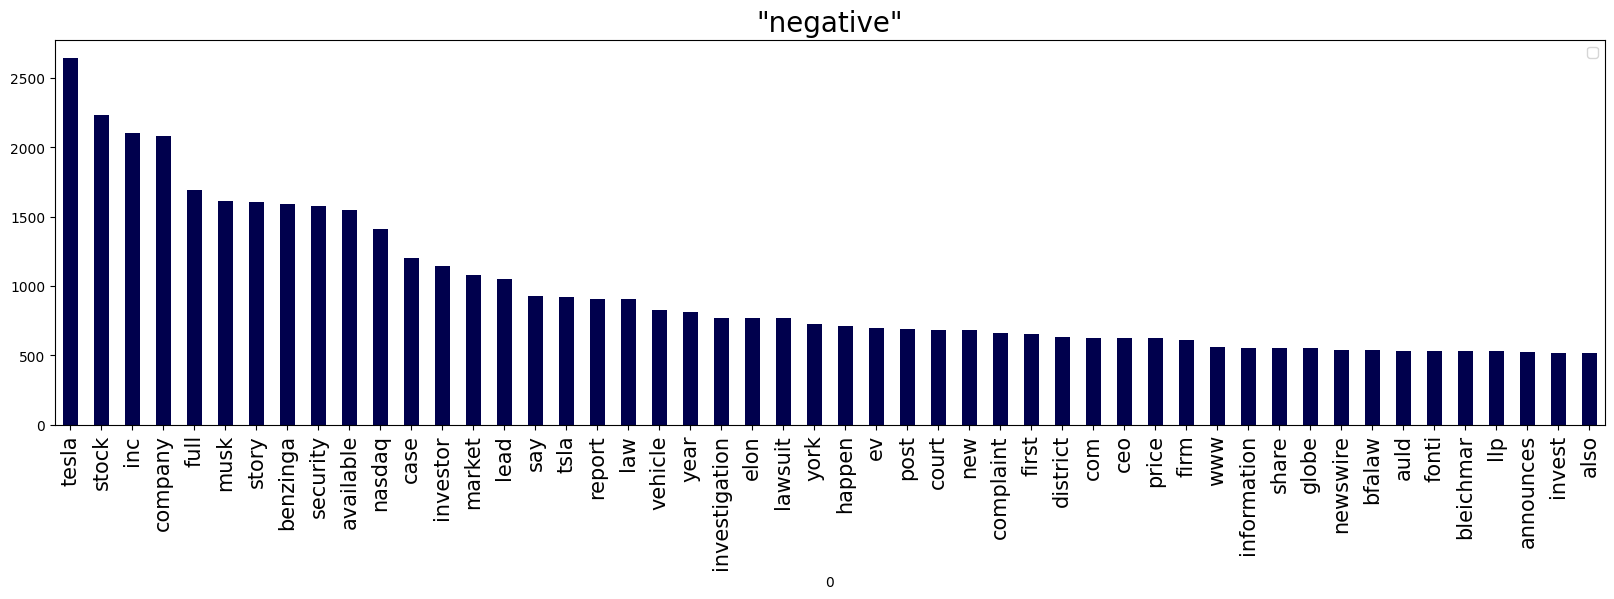

<ipython-input-36-3495920787>:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


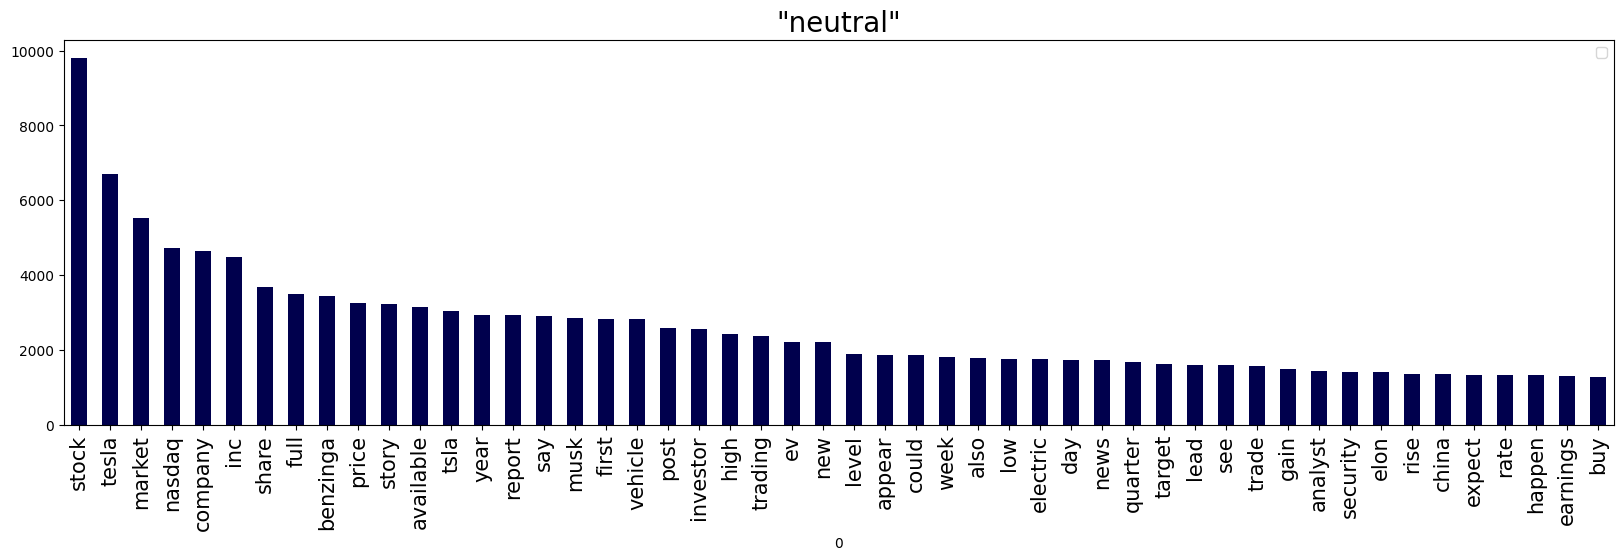

<ipython-input-36-3495920787>:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


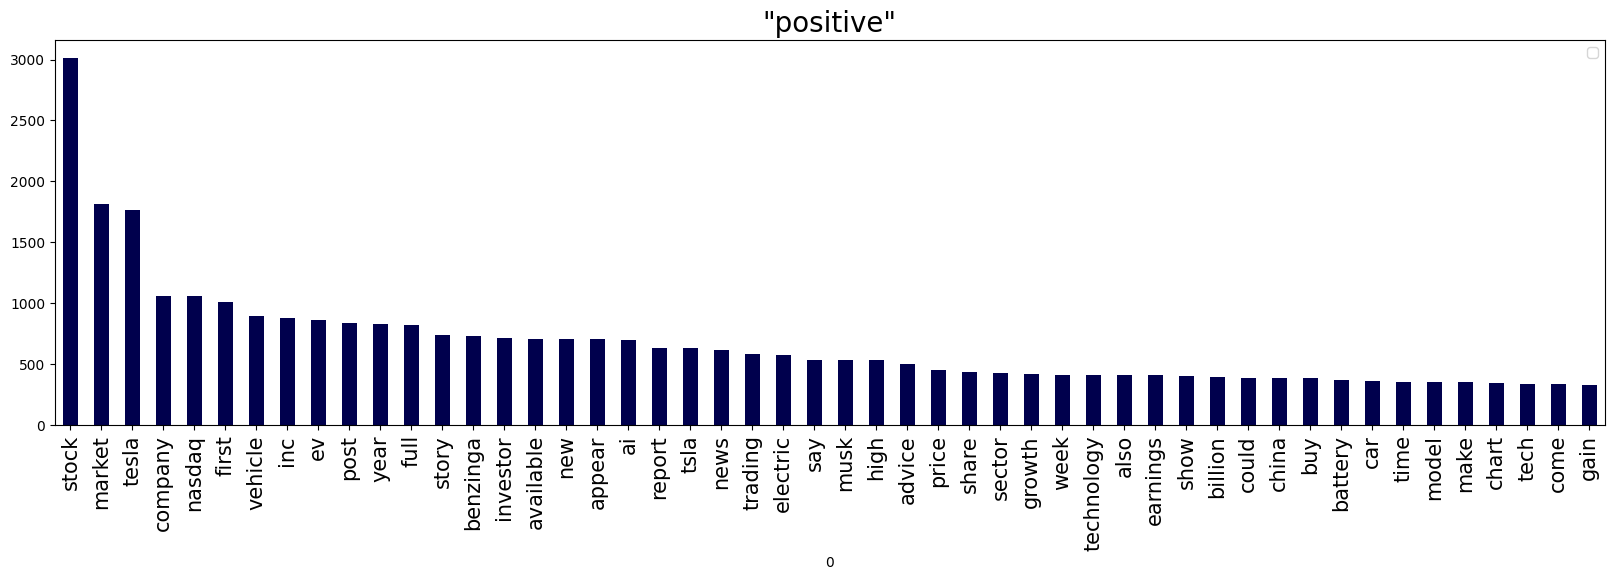

In [39]:
plot_most_common_features(df_en.clean_description, df_en.sentiment)

In [40]:
#We have found that "title" extracts the releavnt keywords (BAG OF WORDS) necessary for sentimental analysis
# Next approach should be applying: BAG OF WORDS Weighting Schemas → TF-IDF Weighting (Use this as the feature for the ML prediction)

In [41]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Your preprocessed DataFrame
df_en["text"] = (
    df_en["clean_title"].fillna("") + " " +
    df_en["clean_description"].fillna("") + " " +
    df_en["clean_content"].fillna("")
)

# Encode sentiment
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df_en["label"] = df_en["sentiment"].str.strip('"').map(label_map).astype(int)

# Manual stratified split using scikit-learn
train_df, test_df = train_test_split(df_en[["text", "label"]], test_size=0.2, stratify=df_en["label"], random_state=42)

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))


In [42]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

# Apply tokenizer to both datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/9965 [00:00<?, ? examples/s]

Map:   0%|          | 0/2492 [00:00<?, ? examples/s]

In [44]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer
)


<ipython-input-44-2309316110>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [45]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [46]:
trainer.train()


Step,Training Loss
500,0.657500
1000,0.405200
1500,0.245600


TrainOutput(global_step=1869, training_loss=0.38450922182755654, metrics={'train_runtime': 714.5404, 'train_samples_per_second': 41.838, 'train_steps_per_second': 2.616, 'total_flos': 1980091752906240.0, 'train_loss': 0.38450922182755654, 'epoch': 3.0})

In [47]:
preds = trainer.predict(tokenized_test)

y_pred = preds.predictions.argmax(-1)

# Extract true labels
y_true = preds.label_ids

# Import and print classification report
from sklearn.metrics import classification_report
label_names = ["negative", "neutral", "positive"]
print(classification_report(y_true, y_pred, target_names=label_names))


              precision    recall  f1-score   support

    negative       0.84      0.84      0.84       592
     neutral       0.88      0.89      0.88      1477
    positive       0.78      0.74      0.76       423

    accuracy                           0.85      2492
   macro avg       0.83      0.82      0.83      2492
weighted avg       0.85      0.85      0.85      2492



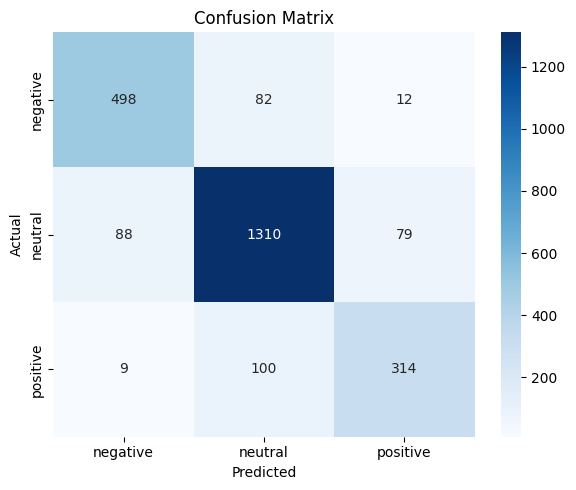

In [48]:
# 🔹 Step 6: Confusion Matrix Plot
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d",
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [49]:
# 🔹 Step 7 (Optional): Print Overall Accuracy
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred)
print(f"🎯 Model Accuracy: {acc:.2%}")


🎯 Model Accuracy: 85.15%


In [50]:
# Save model and tokenizer
model.save_pretrained("bert_sentiment_model")
tokenizer.save_pretrained("bert_sentiment_model")


('bert_sentiment_model/tokenizer_config.json',
 'bert_sentiment_model/special_tokens_map.json',
 'bert_sentiment_model/vocab.txt',
 'bert_sentiment_model/added_tokens.json',
 'bert_sentiment_model/tokenizer.json')

In [57]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("bert_sentiment_model")
model = AutoModelForSequenceClassification.from_pretrained("bert_sentiment_model")


In [61]:
id2label = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

inputs = tokenizer("This is bad!", return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
pred = logits.argmax(dim=1).item()

print("Prediction label:", id2label[pred])



Prediction label: negative


In [62]:
!zip -r /content/file.zip /content/bert_sentiment_model


  adding: content/bert_sentiment_model/ (stored 0%)
  adding: content/bert_sentiment_model/model.safetensors (deflated 8%)
  adding: content/bert_sentiment_model/config.json (deflated 49%)
  adding: content/bert_sentiment_model/special_tokens_map.json (deflated 42%)
  adding: content/bert_sentiment_model/vocab.txt (deflated 53%)
  adding: content/bert_sentiment_model/tokenizer.json (deflated 71%)
  adding: content/bert_sentiment_model/tokenizer_config.json (deflated 75%)


In [63]:

from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

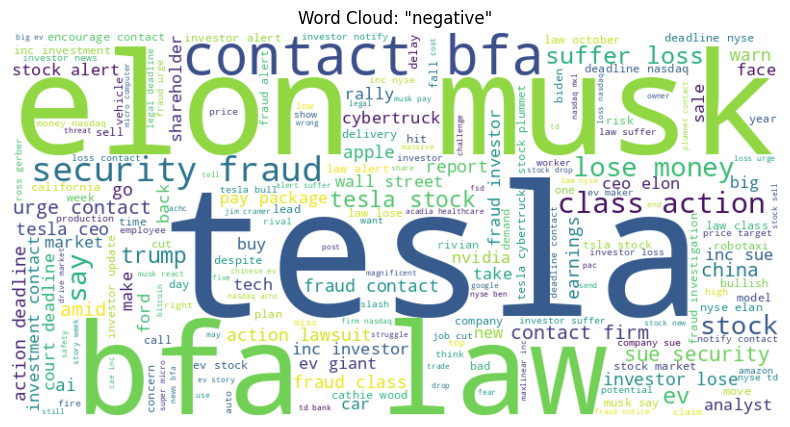

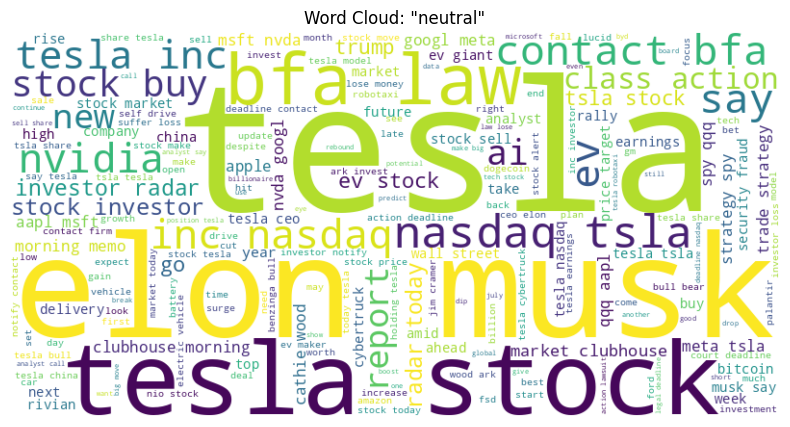

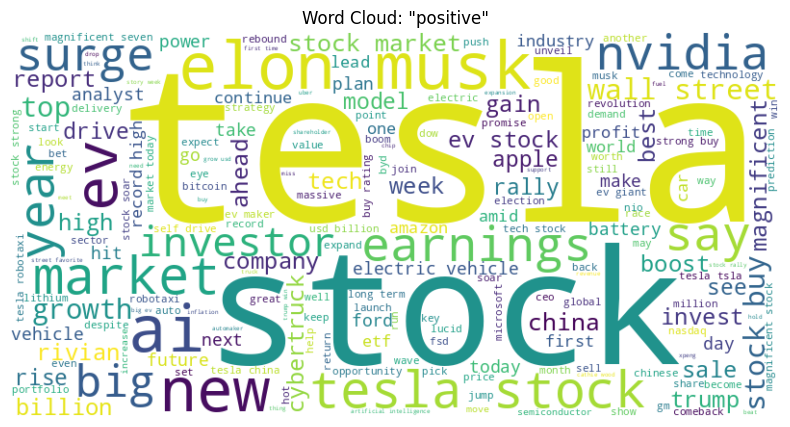

In [51]:
from wordcloud import WordCloud

# Combine titles by sentiment
sentiment_groups = df_en.groupby("sentiment")["clean_title"].apply(lambda x: " ".join(x))

# Generate word clouds
for sentiment, text in sentiment_groups.items():
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud: {sentiment}")
    plt.show()


## 🧠 Insights from TF-IDF Term Analysis

By analyzing the top TF-IDF terms per class, we can see which words were most influential in predicting each sentiment:

- 🔴 **Negative**: Words like *"lost"*, *"warn"*, *"fraud"*, and *"disappoint"* indicate fear, decline, or failure — aligning well with negative sentiment.
- ⚪ **Neutral**: Terms such as *"tsla"*, *"nasdaq"*, and *"update"* show neutral reporting or stock movement without emotional tone.
- 🟢 **Positive**: Positive terms like *"boost"*, *"soar"*, *"strong"*, and *"success"* signal financial growth or positive events.

These visualizations validate the model’s decision-making and add transparency to the prediction process.


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16494 entries, 0 to 16493
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_id       16494 non-null  object
 1   title            16494 non-null  object
 2   link             16494 non-null  object
 3   keywords         12090 non-null  object
 4   creator          14762 non-null  object
 5   video_url        2 non-null      object
 6   description      16026 non-null  object
 7   content          14697 non-null  object
 8   pubDate          16494 non-null  object
 9   pubDateTZ        16494 non-null  object
 10  image_url        14663 non-null  object
 11  source_id        16494 non-null  object
 12  source_priority  16494 non-null  object
 13  source_name      16426 non-null  object
 14  source_url       16425 non-null  object
 15  source_icon      16361 non-null  object
 16  language         16494 non-null  object
 17  country          16491 non-null

In [53]:
df['pubDate']

,pubDate
0,"""2025-01-15 22:16:52"""
1,"""2025-01-15 22:00:00"""
2,"""2025-01-15 21:31:16"""
3,"""2025-01-15 21:30:58"""
4,"""2025-01-15 21:18:04"""
...,...
16489,"""2024-01-01 13:56:17"""
16490,"""2024-01-01 12:08:00"""
16491,"""2024-01-01 07:00:14"""
16492,"""2024-01-01 04:40:27"""


In [54]:
df["pubDate"] = df["pubDate"].str.strip('"')
df["pubDate"] = pd.to_datetime(df["pubDate"], utc=True)
df["pubDate_day"] = df["pubDate"].dt.floor("D")

ValueError: time data "investorplace" doesn't match format "%Y-%m-%d %H:%M:%S", at position 514. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
import yfinance as yf

tesla = yf.download("TSLA", start="2024-01-01", end="2025-01-16", interval="1d")

tesla = tesla.reset_index()

if isinstance(tesla.columns, pd.MultiIndex):
    tesla.columns = tesla.columns.get_level_values(0)

# Ensure Date is datetime
tesla["Date"] = pd.to_datetime(tesla["Date"], utc=True)

merged = df.merge(tesla, left_on="pubDate_day", right_on="Date", how="left")

merged = merged[["pubDate", "sentiment", "Open", "High", "Low", "Close", "Volume"]]

In [ ]:
merged.tail(100)

In [ ]:
merged.dropna(inplace=True)
merged.info()

In [ ]:
merged["sentiment"] = merged["sentiment"].str.strip('"')

merged["pos"] = (merged["sentiment"] == "positive").astype(int)
merged["neg"] = (merged["sentiment"] == "negative").astype(int)
merged["neu"] = (merged["sentiment"] == "neutral").astype(int)

merged["date"] = merged["pubDate"].dt.floor("D")
sentiment_daily = merged.groupby("date")[["pos", "neg", "neu"]].sum()

# Get daily Tesla prices
price_cols = ["Open", "High", "Low", "Close", "Volume"]
tesla_daily = merged.groupby("date")[price_cols].first()

# Combine features
features = pd.concat([tesla_daily, sentiment_daily], axis=1)

# Target: next day's close
features["target"] = features["Close"].shift(-1)
features.dropna(inplace=True)

features

In [ ]:
features["return_1d"] = features["Close"].pct_change()
features["volatility_3d"] = features["Close"].pct_change().rolling(3).std()
features["momentum_3d"] = features["Close"] - features["Close"].shift(3)

total = features[["pos", "neg", "neu"]].sum(axis=1)
features["sentiment_score"] = (features["pos"] - features["neg"]) / total.replace(0, 1)

features["Close_lag1"] = features["Close"].shift(1)
features["pos_lag1"] = features["pos"].shift(1)

features.dropna(inplace=True)
features.drop(columns=["Open", "High", "Low"], inplace=True)

features

In [ ]:
from xgboost import XGBClassifier

features["target"] = (features["Close"].shift(-1) > features["Close"]).astype(int)

features.dropna(inplace=True)

# Train/test split
X = features.drop(columns=["target"])
y = features["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


# XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
import joblib

joblib.dump(model, "xgb_direction_model.pkl")